In [1]:
# left: jacobin
# central: reuters
# right: newsmax

In [58]:
import random
import requests

def fetch_jacobin_article_fragments(article_url):
    print(f"fetching article: {article_url}")

    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return None

        soup = BeautifulSoup(response.content, "html.parser")

        body = soup.select("div#post-content")
        content = " ".join(p.get_text(strip=True) for p in body)
        print(f"article content: {content}")

        # fragments containing "Trump" or "Biden"
        fragments = []
        sentences = re.split(r'(?<=[.!?])\s+', content)
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Biden)\b', sentence, re.IGNORECASE):
                # choose 1,2,3 consecutive sentences
                num_sentences = random.choice([1, 2, 3])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        print(f"relevant fragments: {fragments}")
        return fragments
    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return None

def fetch_jacobin_data(url, max_texts=100):
    fragments = []
    base_url = "https://jacobin.com"
    page = 1

    while len(fragments) < max_texts:
        paginated_url = f"{url}&page={page}"
        response = requests.get(paginated_url)
        if response.status_code != 200:
            print(f"Failed to fetch page {page}: {response.status_code}")
            break

        soup = BeautifulSoup(response.content, "html.parser")
        divs = soup.find_all("div", class_="ar-mn__main")
        article_links = []
        for div in divs:
            a_tags = div.find_all("a")
            for a_tag in a_tags:
                href = a_tag.get("href")
                if href:
                    article_links.append(href)
                    break  # there are 2 links to each article

        if not article_links:
            print("No more articles found.")
            break

        for link in article_links:
            if len(fragments) >= max_texts:
                break

            article_url = base_url + link
            article_fragments = fetch_jacobin_article_fragments(article_url)
            if article_fragments:
                fragments.extend([(frag, "left") for frag in article_fragments])

        page += 1

    return fragments[:max_texts]

def get_2020_data_jacobin():
  # Trump vs Biden
  data = [] # (text, leaning), leaning="left"

  urls = ["https://jacobin.com/search?query=+donald+trump+2020+elections", "https://jacobin.com/search?query=donald+trump+presidential+candidate+2020",
          "https://jacobin.com/search?query=joe+biden+2020+elections", "https://jacobin.com/search?query=joe+biden+2020+presidential+rally"]
  for url in urls:
    data += fetch_jacobin_data(url, max_texts=100)
  return data

In [20]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 22.7 MB/s eta 0:00:00


In [65]:
import requests
from bs4 import BeautifulSoup
import re
import random
import time

def fetch_google_search_apnews_results(query_url, max_results=10):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }

    try:
        response = requests.get(query_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch search results: {response.status_code}")
            return []

        soup = BeautifulSoup(response.text, "html.parser")
        links = soup.find_all("a")
        article_urls = []
        for link in links:
            href = link.get("href")
            if href and "apnews.com" in href:  # Filter AP News links
                matched = re.search(r"https://apnews.com/[^\s&]*", href)
                if matched:
                    article_url = matched.group(0)
                    if article_url not in article_urls:
                        article_urls.append(article_url)
            if len(article_urls) >= max_results:
                break

        return article_urls

    except Exception as e:
        print(f"Error fetching Google search results: {e}")
        return []

def fetch_apnews_article_fragments(article_url):
    print(f"Fetching AP News article: {article_url}")
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }

    try:
        response = requests.get(article_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return []

        soup = BeautifulSoup(response.content, "html.parser")
        body = soup.find("div", {"class": "Page-storyBody"})

        content = " ".join(p.get_text(strip=True) for p in body.find_all("p"))
        sentences = re.split(r'(?<=[.!?])\s+', content)

        fragments = []
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Biden)\b', sentence, re.IGNORECASE):
                num_sentences = random.choice([2, 3, 4])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        return fragments

    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return []

def fetch_apnews_data(query_url, max_texts=100):
    article_urls = fetch_google_search_apnews_results(query_url, max_results=max_texts)
    all_fragments = []
    for url in article_urls:
        fragments = fetch_apnews_article_fragments(url)
        all_fragments.extend((fragment, "center") for fragment in fragments)
        if len(all_fragments) >= max_texts:
            break
        time.sleep(random.uniform(1, 2))
    return all_fragments

def get_2020_data_apnews():
    data = []  # (text, leaning), leaning="center"
    urls = [
        "https://www.google.com/search?q=site%3Aapnews.com+donald+trump+2020+elections+after%3A2018-01-01+before%3A2021-06-01",
        "https://www.google.com/search?q=site%3Aapnews.com+joe+biden+2020+elections+after%3A2018-01-01+before%3A2021-06-01"
    ]
    for url in urls:
        data += fetch_apnews_data(url, max_texts=230)
    return data


In [66]:
import requests
from bs4 import BeautifulSoup
import re
import random
import time

def fetch_google_search_newsmax_results(query_url, max_results=10):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }

    try:
        response = requests.get(query_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch google results: {response.status_code}")
            return []

        soup = BeautifulSoup(response.text, "html.parser")
        links = soup.find_all("a")
        article_urls = []
        for link in links:
            href = link.get("href")
            if href and "newsmax.com" in href:
                matched = re.search(r"https://www\.newsmax\.com/[^\s&]*", href)
                if matched:
                    article_url = matched.group(0)
                    if article_url not in article_urls:
                        article_urls.append(article_url)
            if len(article_urls) >= max_results:
                break

        return article_urls

    except Exception as e:
        print(f"Error fetching Google search results: {e}")
        return []

def fetch_newsmax_article_fragments(article_url):
    print(f"Fetching Newsmax article: {article_url}")

    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return []

        soup = BeautifulSoup(response.content, "html.parser")
        body = soup.find("div", {"id": "mainArticleDiv"})

        content = " ".join(p.get_text(strip=True) for p in body.find_all("p"))
        sentences = re.split(r'(?<=[.!?])\s+', content)

        fragments = []
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Biden)\b', sentence, re.IGNORECASE): # sentences mentioning either candidate
                num_sentences = random.choice([2, 3, 4])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        return fragments

    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return []

def fetch_newsmax_data(query_url, max_texts=100):
    article_urls = fetch_google_search_newsmax_results(query_url, max_results=max_texts)
    all_fragments = []
    for url in article_urls:
        fragments = fetch_newsmax_article_fragments(url)
        all_fragments.extend((fragment, "right") for fragment in fragments)
        if len(all_fragments) >= max_texts:
            break
        time.sleep(random.uniform(1, 2))
    return all_fragments

def get_2020_data_newsmax():
    data = []  # (text, leaning), leaning="right"
    urls = [
        "https://www.google.com/search?q=site%3Anewsmax.com+donald+trump+2020+elections+after%3A2018-01-01+before%3A2021-06-01",
        "https://www.google.com/search?q=site%3Anewsmax.com+joe+biden+2020+elections+after%3A2018-01-01+before%3A2021-06-01"
    ]
    for url in urls:
        data += fetch_newsmax_data(url, max_texts=800)
    return data


In [61]:
def get_data_for_year(year):
  if year == 2020:
    data = []
    data += get_2020_data_jacobin()
    data += get_2020_data_apnews()
    data += get_2020_data_newsmax()

    return data

In [67]:
data_2020 = get_data_for_year(2020)

print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")

fetching article: https://jacobin.com/2017/09/democratic-party-2016-election-working-class
article content: Even before Donald Trump’s shocking victory last November, the press had alreadywrittenthe story of his rise. Despitestudiesshowing that, likeall Republican candidates, well-off whites formed the core of Trump’s support, pundits zeroed in on his white working-class backers, which most commentators defined solely in terms of education (whites without a college degree).This dividing line ignored other crucial variables — such as income, self-identification, and occupation — but it fit with the popular belief that, from the office cubicle to the voting booth, the postindustrial “New Economy” separated the intelligent from the ignorant in a virtuousmeritocracy.By the time Hillary Clinton conceded to Trump, non-college whites had become conflated with both the working class and racism itself. The Trump campaign, as one punditargued, “laid bare the racial animus within the white workin

In [68]:
print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")
print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")
print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")


data_2020[...]:('Even before Donald Trump’s shocking victory last November, the press had alreadywrittenthe story of his rise. Despitestudiesshowing that, likeall Republican candidates, well-off whites formed the core of Trump’s support, pundits zeroed in on his white working-class backers, which most commentators defined solely in terms of education (whites without a college degree).This dividing line ignored other crucial variables —\xa0such as income, self-identification, and occupation — but it fit with the popular belief that, from the office cubicle to the voting booth, the postindustrial “New Economy” separated the intelligent from the ignorant in a virtuousmeritocracy.By the time Hillary Clinton conceded to Trump, non-college whites had become conflated with both the working class and racism itself.', 'left')
data_2020[...]:('Telegraphing theconsensusview, VoxcalledTrump’s nomination “a remarkable example of a major political party blowing a totally winnable national election” 

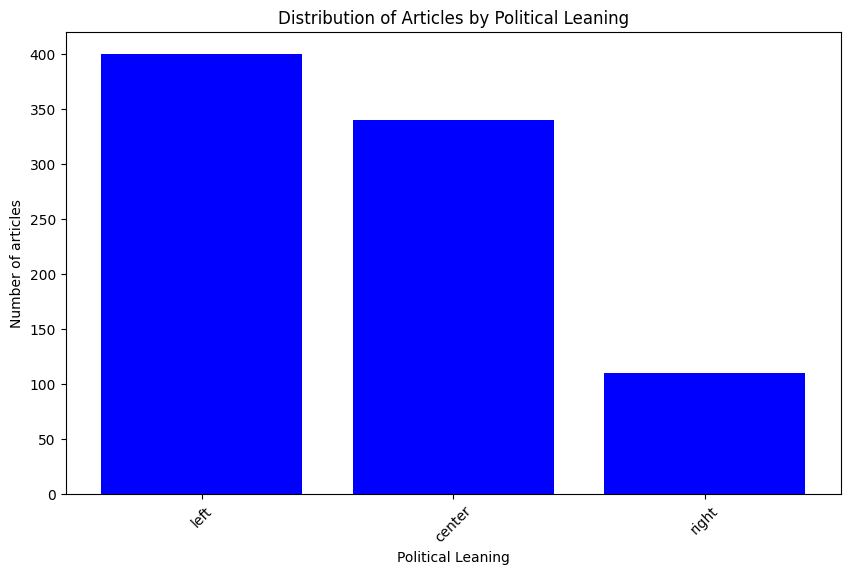

Total articles: 850
Distribution by political leaning:
left: 400
center: 340
right: 110


In [69]:
# data analysis

from collections import Counter
import matplotlib.pyplot as plt

def display_statistics(data):
    leanings = [fragment[1] for fragment in data] # data: [(text, leaning), ...]
    counts = Counter(leanings)

    labels = counts.keys()
    values = counts.values()

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='blue')
    plt.xlabel('Political Leaning')
    plt.ylabel('Number of articles')
    plt.title('Distribution of Articles by Political Leaning')
    plt.xticks(rotation=45)
    plt.show()

    print("Total articles:", len(data))
    print("Distribution by political leaning:")
    for leaning, count in counts.items():
        print(f"{leaning}: {count}")

display_statistics(data_2020)


In [ ]:
import csv

def save_data(data, filename="2020_election_data.csv"):
    data_with_year = [(text, leaning, 2020) for text, leaning in data]

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Text", "Leaning", "Year"])
        writer.writerows(data_with_year)

    print(f"Saved to {filename}")